## Extracting and Loading X-Ray Data

/var/folders/md/qxkcfv650bx_kd_5hlgqrct40000gn/T/ipykernel_1090/4277042677.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using previously extracted files...
Loading dataset from ./data/NIH/extracted/images-224
Dataset size: 28868

Available pathologies:
1. Atelectasis
2. Cardiomegaly
3. Consolidation
4. Edema
5. Effusion
6. Emphysema
7. Fibrosis
8. Hernia
9. Infiltration
10. Mass
11. Nodule
12. Pleural_Thickening
13. Pneumonia
14. Pneumothorax

Pathology counts:
Atelectasis:
  Present: 1557
  Absent: 27311
  Percentage: 5.39%

Cardiomegaly:
  Present: 729
  Absent: 28139
  Percentage: 2.53%

Consolidation:
  Present: 384
  Absent: 28484
  Percentage: 1.33%

Edema:
  Present: 39
  Absent: 28829
  Percentage: 0.14%

Effusion:
  Present: 1269
  Absent: 27599
  Percentage: 4.40%

Emphysema:
  Present: 264
  Absent: 28604
  Percentage: 0.91%

Fibrosis:
  Present: 556
  Absent: 28312
  Percentage: 1.93%

Hernia:
  Present: 81
  Absent: 28787
  Percentage: 0.28%

Infiltration:
  Present: 3273
  Absent: 25595
  Percentage: 11.34%

Mass:
  Present: 1213
  Absent: 27655
  Percentage: 4.20%

Nodule:
  Present: 1609

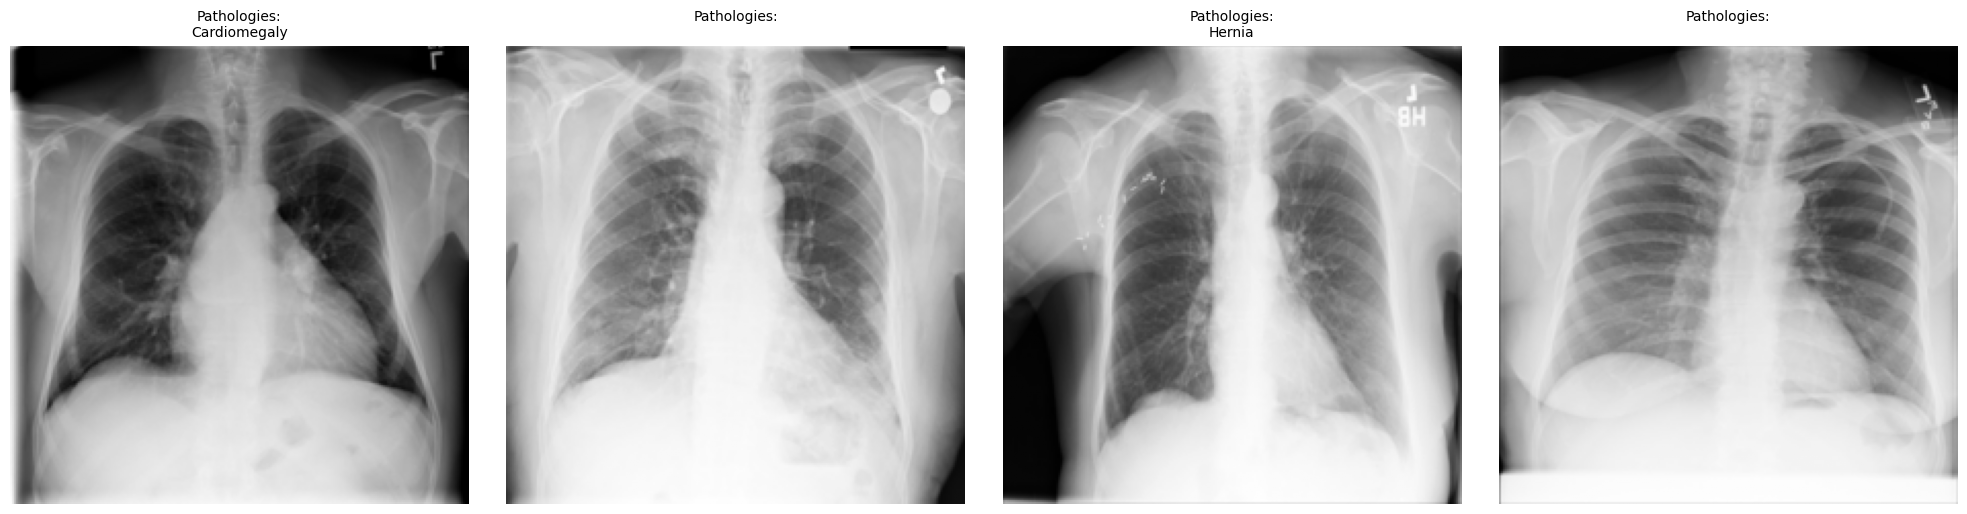

In [1]:
from tqdm.autonotebook import tqdm
from vincent_util_yy import (
    load_nih_dataset,
    print_dataset_info,
    show_sample_images,
    )

imgpath = "./data/NIH/images-224.tar"

# Load dataset
dataset, dataloader = load_nih_dataset(
    imgpath=imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True
)


# Print dataset information
print_dataset_info(dataset)

# Show sample images
show_sample_images(dataset)

## Loading Pre-trained Dense Net Model

In [2]:
import torchxrayvision as xrv

model = xrv.models.DenseNet(weights="densenet121-res224-all")

## Running Base Inference Pipeline with Model

Dataset structure:
Using subset dataset
Original dataset type: <class 'torchxrayvision.datasets.NIH_Dataset'>

Number of pathologies: 14
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Batch information:
Batch type: <class 'dict'>
Batch keys: dict_keys(['idx', 'lab', 'img'])
Images shape: torch.Size([4, 1, 224, 224])
Labels shape: torch.Size([4, 14])

Predictions shape: torch.Size([4, 18])

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pat

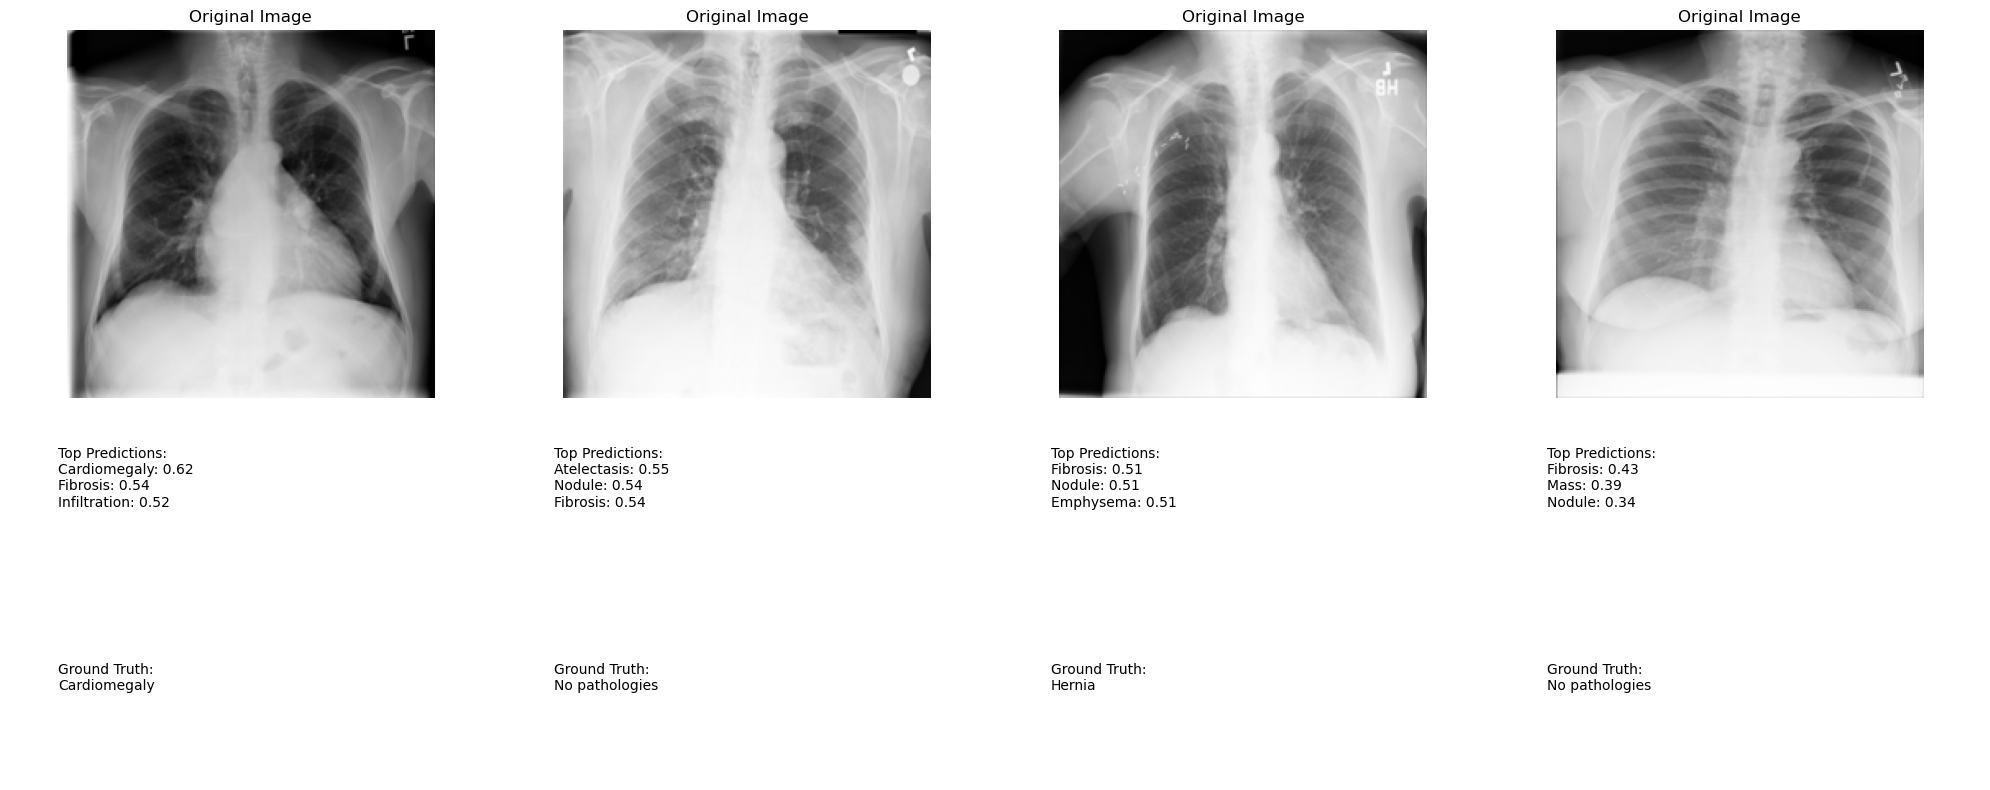

In [3]:
import torch
from torch.utils.data import DataLoader
from vincent_util import run_inference

# Create a small subset for testing
small_subset = torch.utils.data.Subset(dataset, indices=range(4))
test_loader = DataLoader(small_subset, batch_size=4)

# Run inference
preds = run_inference(model, test_loader, num_samples=4)

## Taking subset and splitting into train and test

In [4]:
train_dataset = torch.utils.data.Subset(dataset, indices=range(22000))
train_loader = DataLoader(train_dataset, batch_size=4)

#test_dataset = torch.utils.data.Subset(dataset, indices=range(22000, 28868))
#test_loader = DataLoader(test_dataset, batch_size=6868)

test_dataset = torch.utils.data.Subset(dataset, indices=range(22000, 23000))
test_loader = DataLoader(test_dataset, batch_size=1000)

## Bayesian Estimator

In [5]:
from vincent_util_yy import (
    extract_features,
    reduce_dimensions,
    discretize_features,
    construct_bayesian_network_with_uncertainty,
    simplified_inference_test
)

print("Extracting features...")
features, labels = extract_features(model, train_loader)
# features, labels = extract_features(model, dataloader)

#features, labels = extract_features(model, small_loader)

print("Reducing Dimensionality...")
reduced_features, reducer, scaler = reduce_dimensions(
    features, 
    n_components=25
)

print("Discretizing features...")
discretized_features, bin_edges = discretize_features(reduced_features)

Extracting features...


Extracting features: 100%|██████████| 5500/5500 [10:06<00:00,  9.07it/s]


Reducing Dimensionality...
PCA with 25 components explains 92.60% of variance
Discretizing features...


In [6]:
pathologies = dataset.pathologies
print("Constructing Bayesian network with parameter uncertainty...")
bayes_net, param_samples, data, feature_cols, pathology_cols = construct_bayesian_network_with_uncertainty(
    reduced_features,
    # discretized_features, 
    labels,
    pathologies,
    bayesnet_struct="tree",
)

Constructing Bayesian network with parameter uncertainty...


Building tree: 100%|██████████| 741/741.0 [00:02<00:00, 326.22it/s]


Performing Bayesian parameter estimation...


Sampling parameters: 100%|██████████| 39/39 [00:02<00:00, 18.49it/s]


Dataset structure:
Using subset dataset
Original dataset type: <class 'torchxrayvision.datasets.NIH_Dataset'>

Number of pathologies: 14
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Batch information:
Batch type: <class 'dict'>
Batch keys: dict_keys(['idx', 'lab', 'img'])
Images shape: torch.Size([1000, 1, 224, 224])
Labels shape: torch.Size([1000, 14])

Predictions shape: torch.Size([1000, 18])

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - 

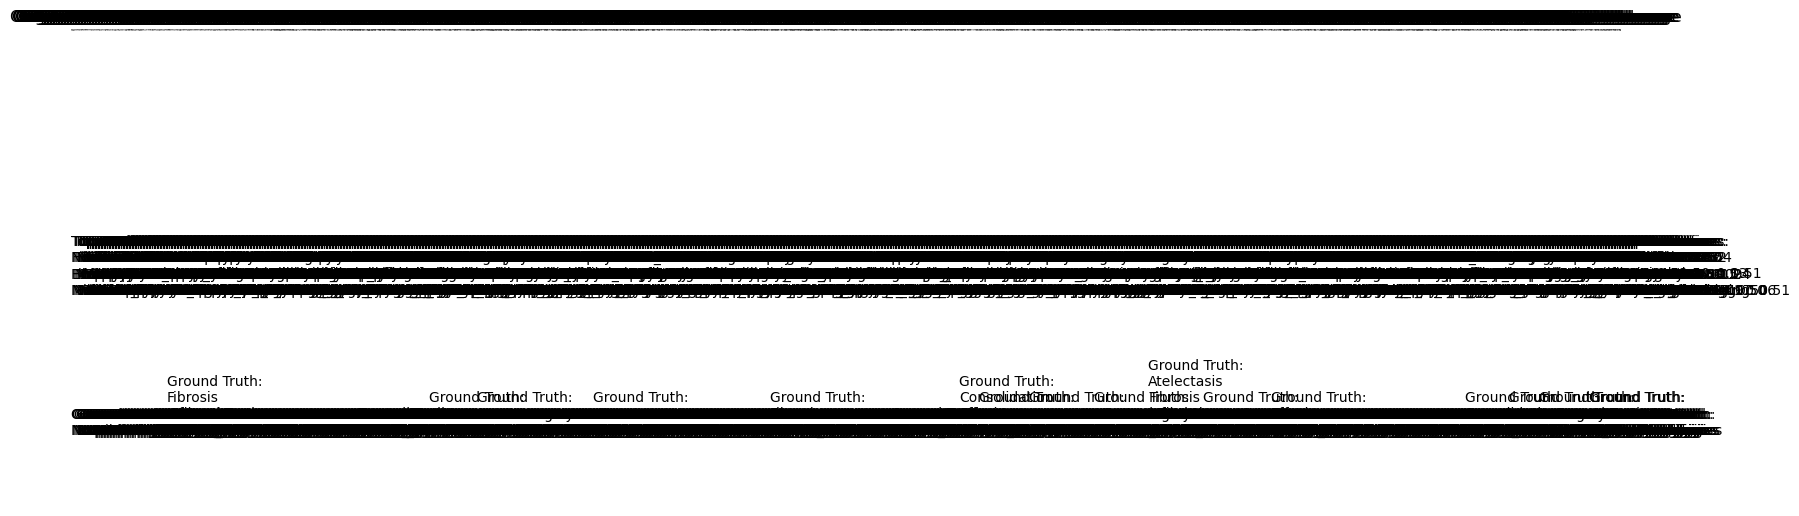

In [7]:
#preds = run_inference(model, test_loader, num_samples=6868)
preds = run_inference(model, test_loader, num_samples=1000)

In [8]:
import pandas as pd 

compiled_dfs = []
#for i in range(6868):
for i in range(1000):
    results_df = simplified_inference_test(
        model=bayes_net,
        param_samples=param_samples,
        data=data,
        feature_cols=feature_cols,
        pathology_cols=pathology_cols,
        base_model_pred=preds[i],
        idx=i,
        n_samples=1000,
        n_test_samples=3
    )
    compiled_dfs.append(results_df)

final_results_df = pd.concat(compiled_dfs)


Processing sample 0 with features: {'f0': 10, 'f1': -14, 'f2': -1, 'f3': 5, 'f4': -2, 'f5': -5, 'f6': 1, 'f7': -2, 'f8': 4, 'f9': -10, 'f10': 11, 'f11': -7, 'f12': 1, 'f13': 1, 'f14': -4, 'f15': -1, 'f16': 0, 'f17': -5, 'f18': -3, 'f19': 1, 'f20': 1, 'f21': 0, 'f22': 1, 'f23': -2, 'f24': 2}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.1588 (Ground truth: 0)
  Cardiomegaly: 0.1870 (Ground truth: 1)
  Consolidation: 0.0730 (Ground truth: 0)
  Edema: 0.0472 (Ground truth: 0)
  Effusion: 0.1159 (Ground truth: 0)
  Emphysema: 0.0151 (Ground truth: 0)
  Fibrosis: 0.1030 (Ground truth: 0)
  Hernia: 0.0051 (Ground truth: 0)
  Infiltration: 0.1447 (Ground truth: 0)
  Mass: 0.1030 (Ground truth: 0)
  Nodule: 0.1373 (Ground truth: 0)
  Pleural_Thicken

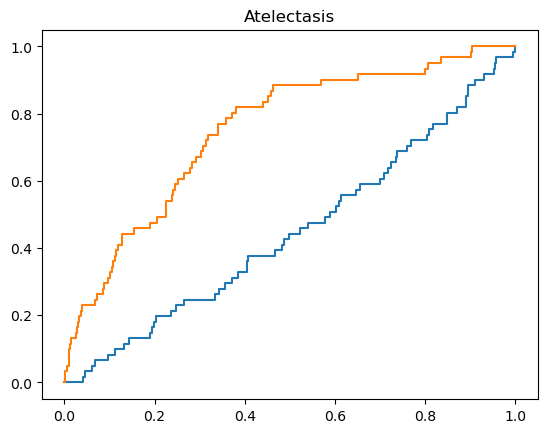

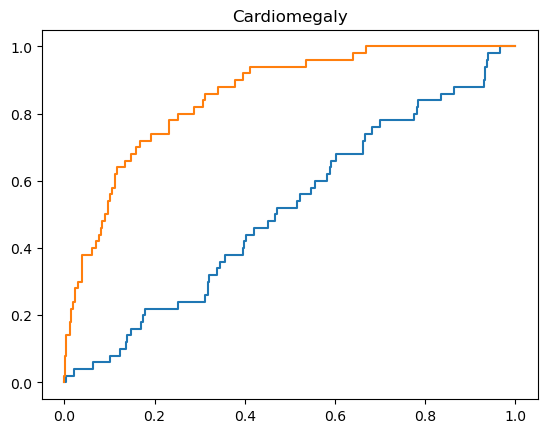

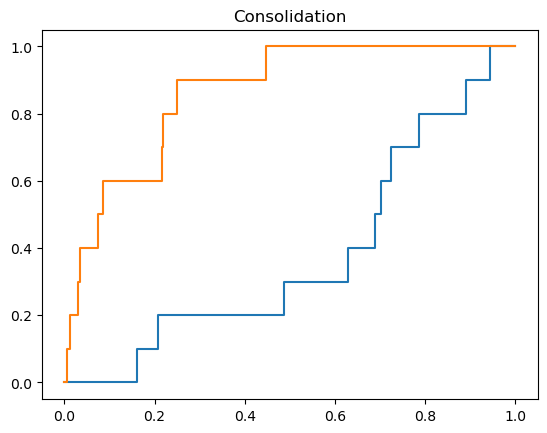

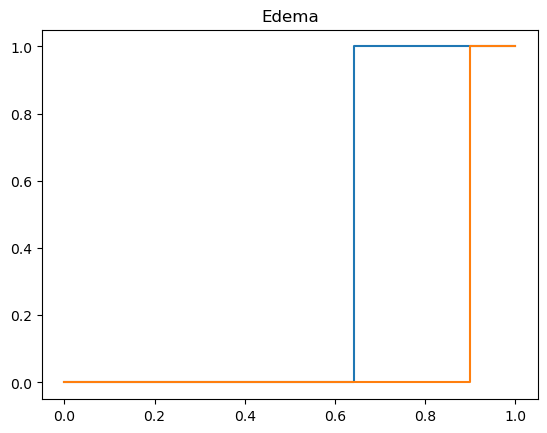

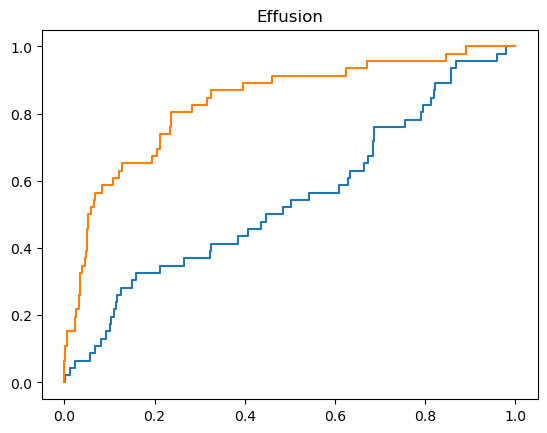

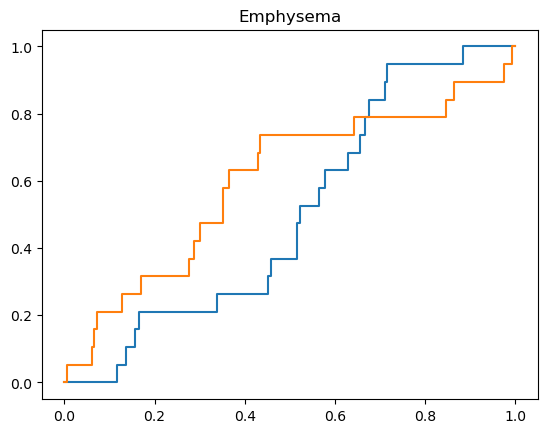

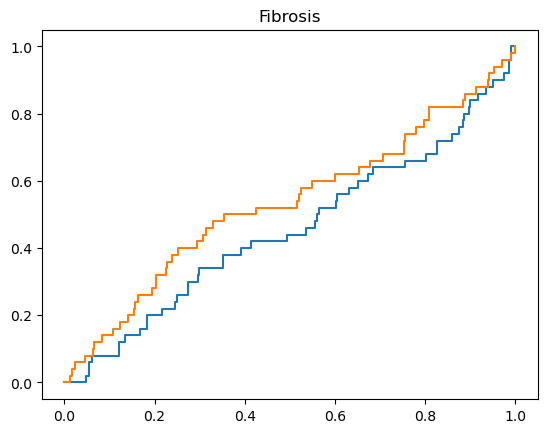

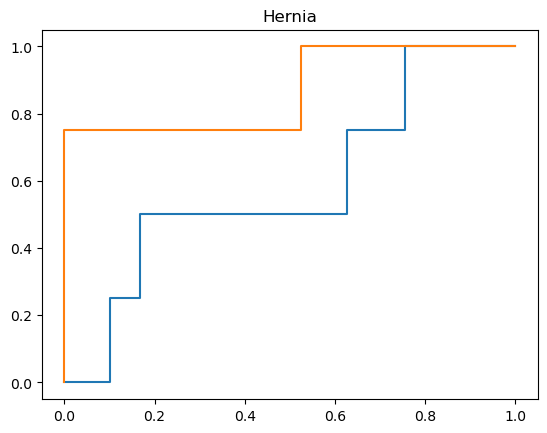

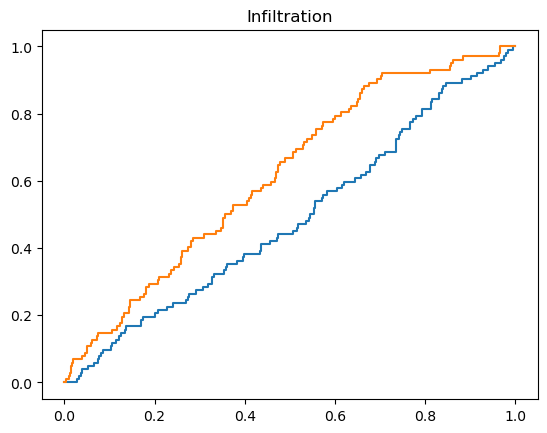

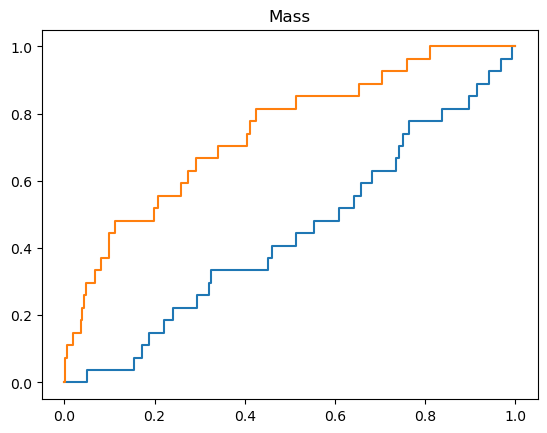

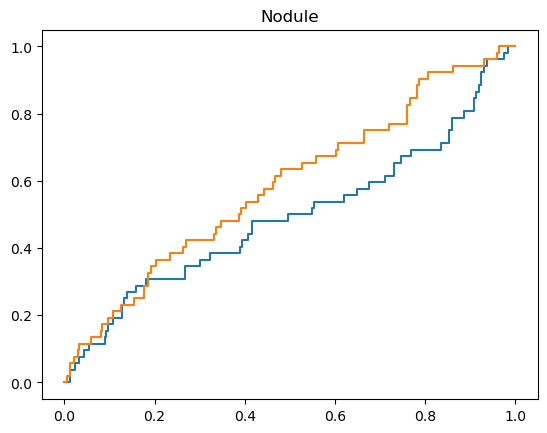

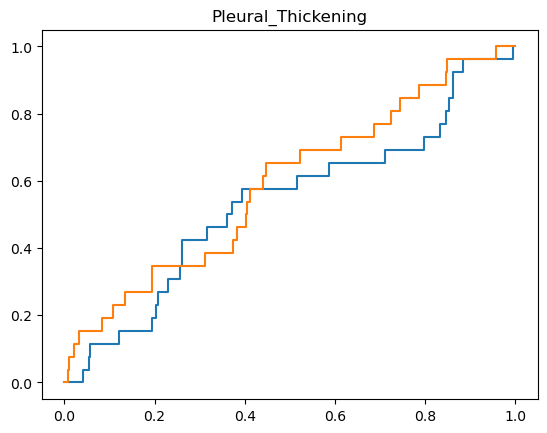

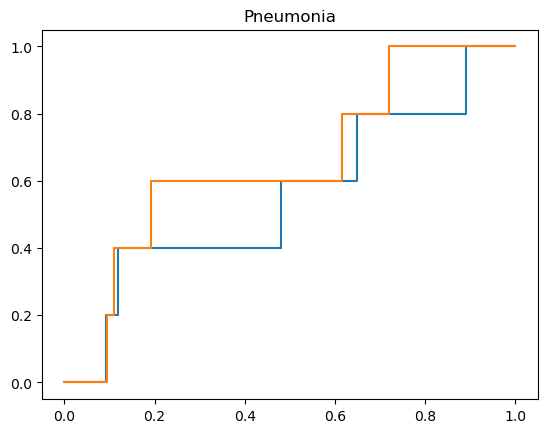

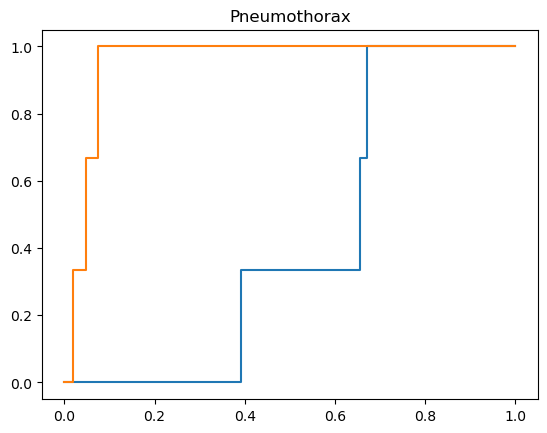

var  base_pred_auc   auc_mle   auc_map  std_ratio  \
0          Atelectasis       0.448402  0.743597  0.750432   1.129233   
1         Cardiomegaly       0.512189  0.842695  0.853600   1.236610   
2        Consolidation       0.377980  0.846970  0.862525   1.210245   
3                Edema       0.357357  0.036036  0.101101   0.953834   
4             Effusion       0.545370  0.833493  0.834268   1.234573   
5            Emphysema       0.501958  0.599147  0.598798   1.038436   
6             Fibrosis       0.454189  0.546653  0.531768   1.020321   
7               Hernia       0.587600  0.869101  0.868725   1.466454   
8         Infiltration       0.485731  0.622134  0.617505   1.035644   
9                 Mass       0.441399  0.751722  0.744052   1.145602   
10              Nodule       0.493894  0.578728  0.587431   1.037872   
11  Pleural_Thickening       0.535618  0.613588  0.588770   1.055753   
12           Pneumonia       0.553769  0.664523  0.653266   1.057698   
13        Pneumothorax       0.427616  0.950853  0.952524   1.323528   

    bayes_winner  
0           True  
1           True  
2           True  
3          False  
4           True  
5           True  
6           True  
7           True  
8           True  
9           True  
10          True  
11          True  
12          True  
13          True

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

base_preds = {}
auc_mle = {}
auc_map = {}
# New dictionaries to store uncertainty metrics
uncertainty_correct_vs_incorrect = {}

for var in final_results_df["var"].unique():
    filt_df = final_results_df.loc[final_results_df["var"] == var]
    '''
    fpr, tpr, thresholds = roc_curve(filt_df["true"], filt_df["base_model"])
    plt.plot(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(filt_df["true"], filt_df["MAP"])
    plt.plot(fpr, tpr)
    plt.title(var)
    plt.show()
    '''
    # Calculate AUC scores as before
    base_preds[var] = roc_auc_score(filt_df["true"], filt_df["base_model"])
    auc_mle[var] = roc_auc_score(filt_df["true"], filt_df["MLE"])
    auc_map[var] = roc_auc_score(filt_df["true"], filt_df["MAP"])
    
    # For each model, compare uncertainty between correct and incorrect predictions
    models = ["base_model", "MLE", "MAP"]
    uncertainty_correct_vs_incorrect[var] = {}
    
    for model in models:
        # Create binary prediction (assuming threshold of 0.5)
        filt_df[f"{model}_pred"] = (filt_df[model] >= 0.5).astype(int)
        
        # Identify correct and incorrect predictions
        correct_mask = filt_df[f"{model}_pred"] == filt_df["true"]
        
        # Get standard deviation for correct vs incorrect predictions
        std_correct = filt_df.loc[correct_mask, "std"].mean()
        std_incorrect = filt_df.loc[~correct_mask, "std"].mean()
        
        # Get credible interval width for correct vs incorrect predictions
        # Assuming credible intervals are stored as tuples in a column named "credible_interval"
        ci_width_correct = filt_df.loc[correct_mask].apply(
            lambda row: row["cred_int"][1] - row["cred_int"][0], axis=1
        ).mean()
        
        ci_width_incorrect = filt_df.loc[~correct_mask].apply(
            lambda row: row["cred_int"][1] - row["cred_int"][0], axis=1
        ).mean()
        
        # Store results
        uncertainty_correct_vs_incorrect[var][model] = {
            "std_correct": std_correct,
            "std_incorrect": std_incorrect,
            "ci_width_correct": ci_width_correct,
            "ci_width_incorrect": ci_width_incorrect,
            "std_ratio": std_incorrect / std_correct if std_correct > 0 else np.nan,
            "ci_width_ratio": ci_width_incorrect / ci_width_correct if ci_width_correct > 0 else np.nan
        }

auc_df = pd.DataFrame({
    "var": final_results_df["var"].unique(),
    "base_pred_auc": base_preds.values(),
    "auc_mle": auc_mle.values(),
    "auc_map": auc_map.values(),
    "std_ratio": [uncertainty_correct_vs_incorrect[diag]['MAP']['std_ratio'] for diag in uncertainty_correct_vs_incorrect]
})

auc_df["bayes_winner"] = auc_df["auc_map"] > auc_df["base_pred_auc"]
auc_df

In [ ]:
auc_df.to_csv("bayes_net_results.csv")


Processing sample 3 with features: {'f0': -21, 'f1': 2, 'f2': -11, 'f3': 7, 'f4': -13, 'f5': -9, 'f6': -2, 'f7': 0, 'f8': 9, 'f9': 1, 'f10': 2, 'f11': 4, 'f12': -2, 'f13': 1, 'f14': 0, 'f15': 0, 'f16': -2, 'f17': 0, 'f18': 3, 'f19': 1, 'f20': 0, 'f21': 1, 'f22': -2, 'f23': -3, 'f24': -1}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0516 (Ground truth: 0)
  Cardiomegaly: 0.0249 (Ground truth: 0)
  Consolidation: 0.0151 (Ground truth: 0)
  Edema: 0.0126 (Ground truth: 0)
  Effusion: 0.0277 (Ground truth: 0)
  Emphysema: 0.0526 (Ground truth: 0)
  Fibrosis: 0.0302 (Ground truth: 0)
  Hernia: 0.0049 (Ground truth: 0)
  Infiltration: 0.0611 (Ground truth: 0)
  Mass: 0.0314 (Ground truth: 0)
  Nodule: 0.0516 (Ground truth: 0)
  Pleural_Thickening

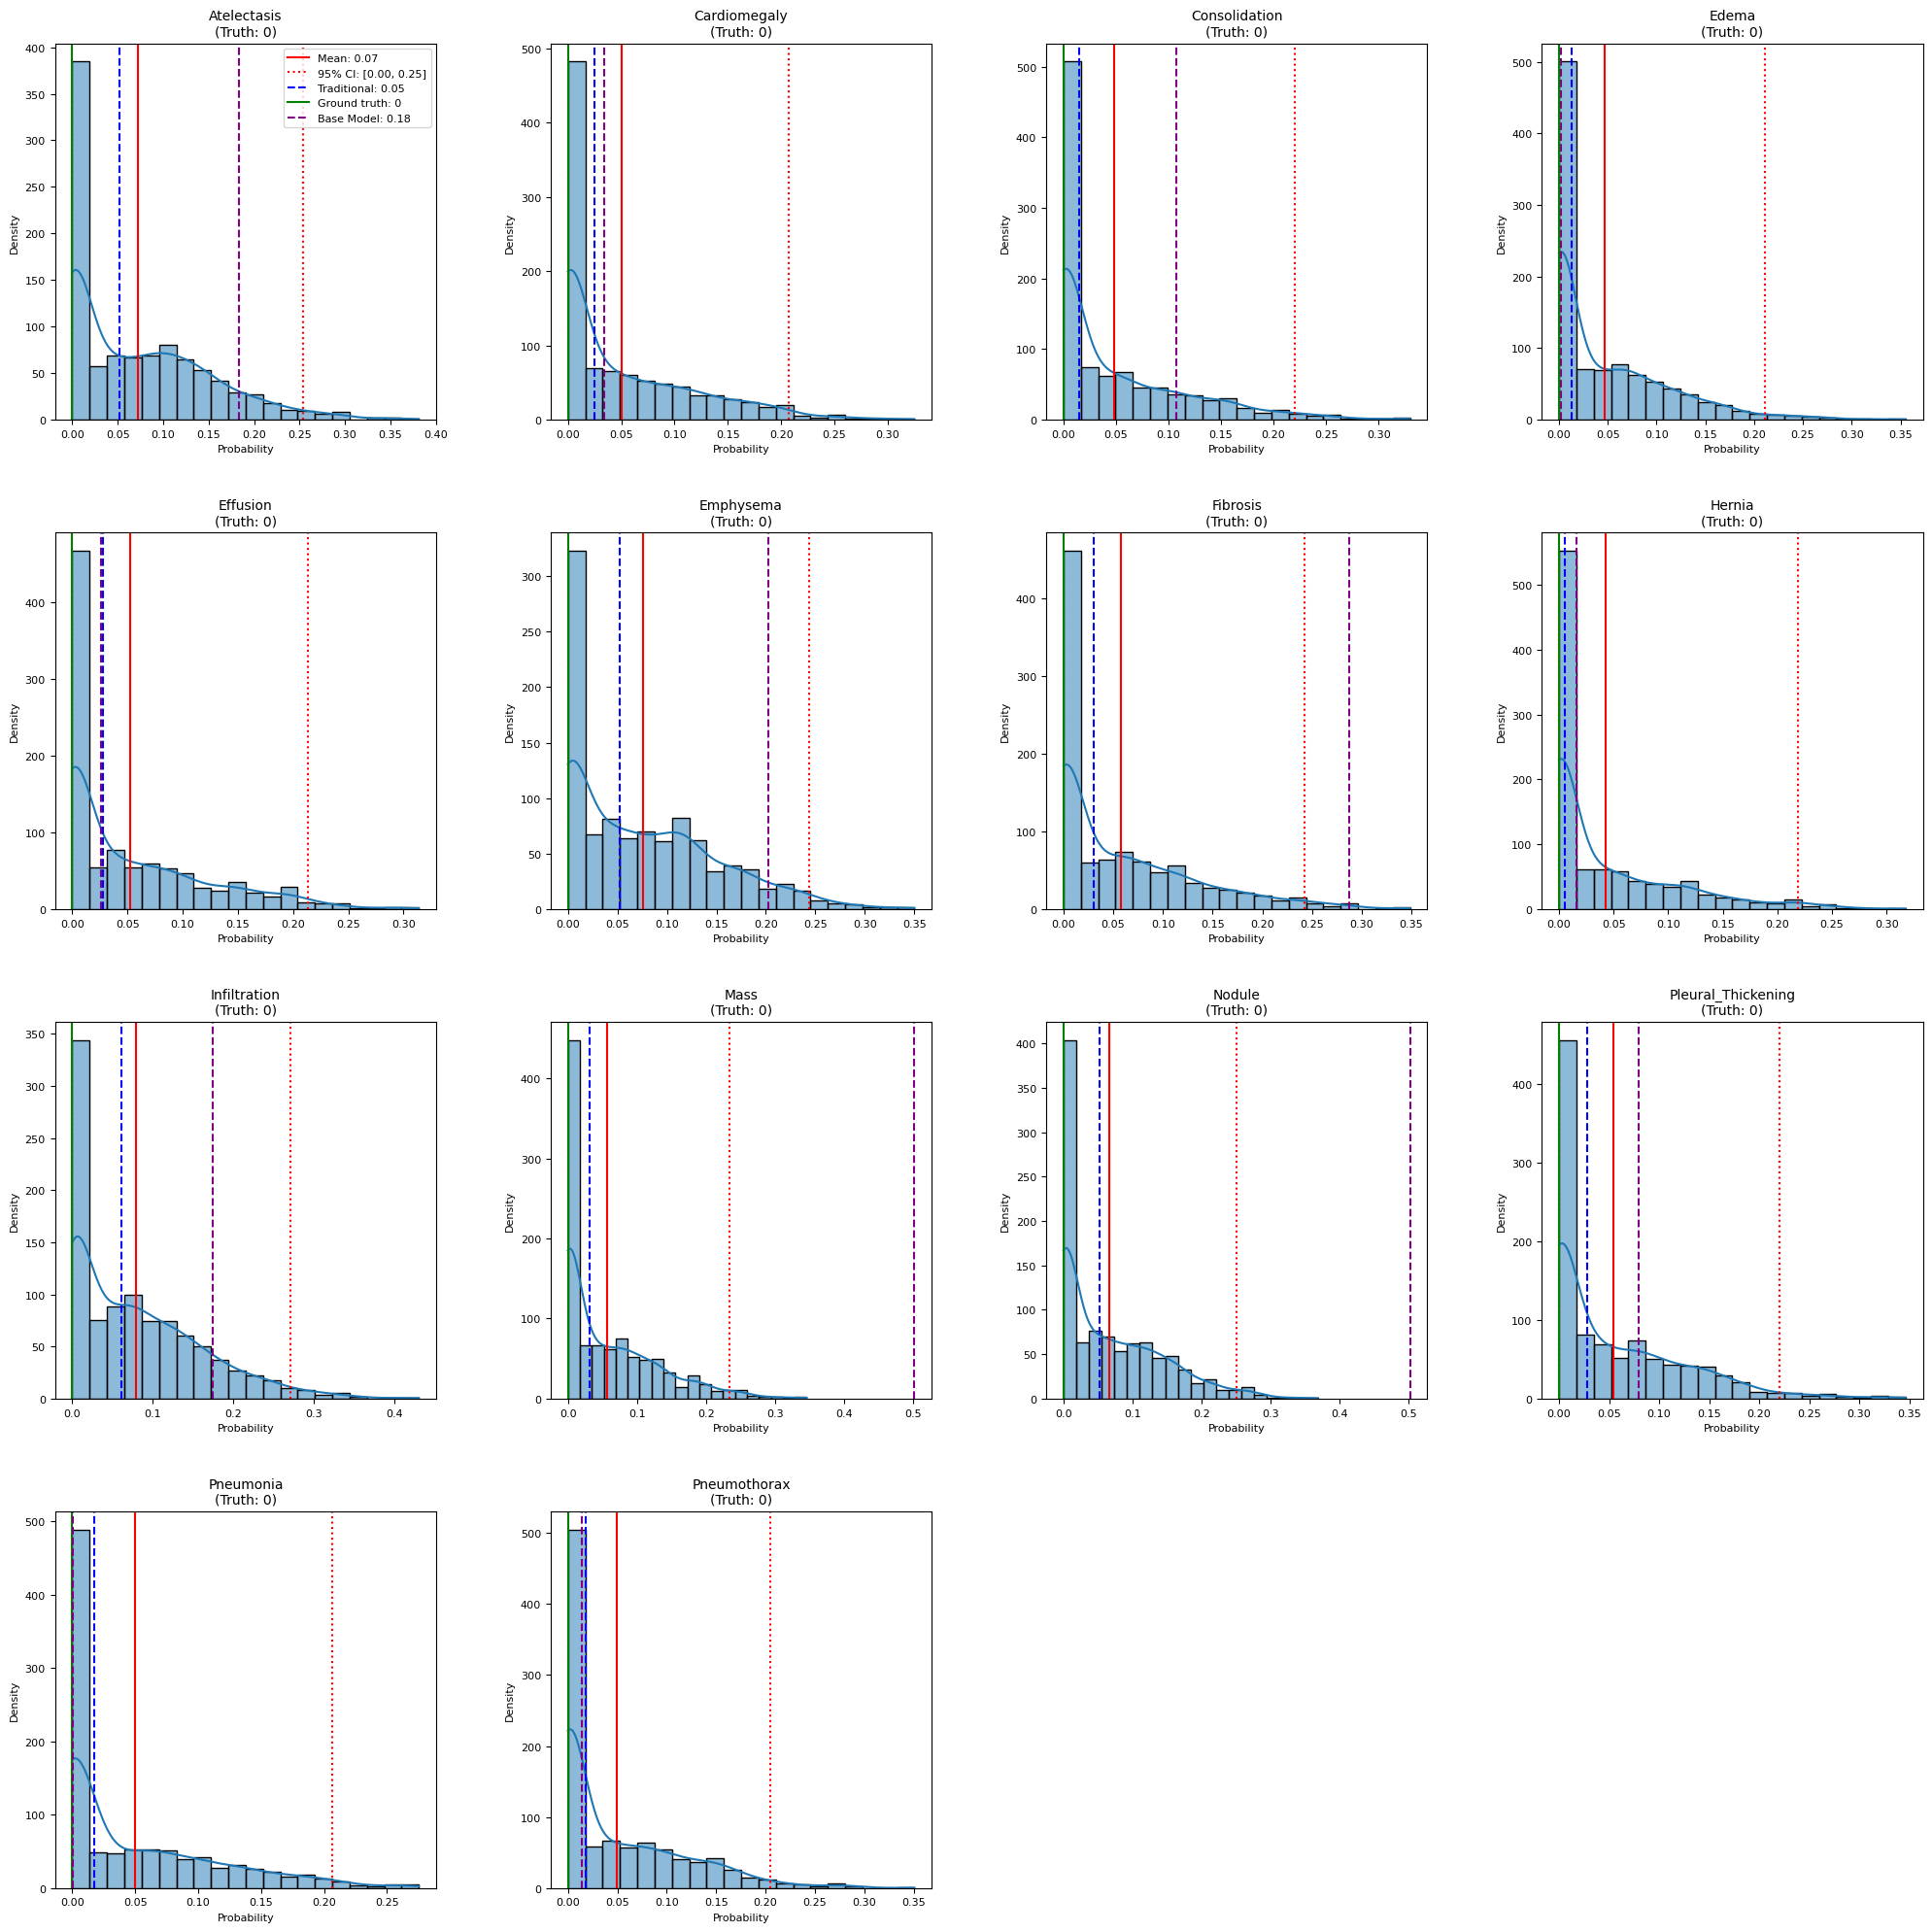

In [42]:
# Healthy Diagnosis Example
simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[3],
    idx=3,
    n_samples=1000,
    n_test_samples=3
)


Processing sample 6 with features: {'f0': -13, 'f1': -1, 'f2': 0, 'f3': -3, 'f4': -3, 'f5': -2, 'f6': 13, 'f7': 1, 'f8': -5, 'f9': -6, 'f10': 15, 'f11': -9, 'f12': 3, 'f13': 4, 'f14': 4, 'f15': 0, 'f16': 0, 'f17': 0, 'f18': 0, 'f19': -2, 'f20': 0, 'f21': -1, 'f22': -1, 'f23': -4, 'f24': 0}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0679 (Ground truth: 0)
  Cardiomegaly: 0.5000 (Ground truth: 1)
  Consolidation: 0.0253 (Ground truth: 0)
  Edema: 0.0158 (Ground truth: 0)
  Effusion: 0.0363 (Ground truth: 0)
  Emphysema: 0.0125 (Ground truth: 0)
  Fibrosis: 0.0427 (Ground truth: 0)
  Hernia: 0.0089 (Ground truth: 0)
  Infiltration: 0.0751 (Ground truth: 0)
  Mass: 0.0553 (Ground truth: 0)
  Nodule: 0.0664 (Ground truth: 0)
  Pleural_Thickeni

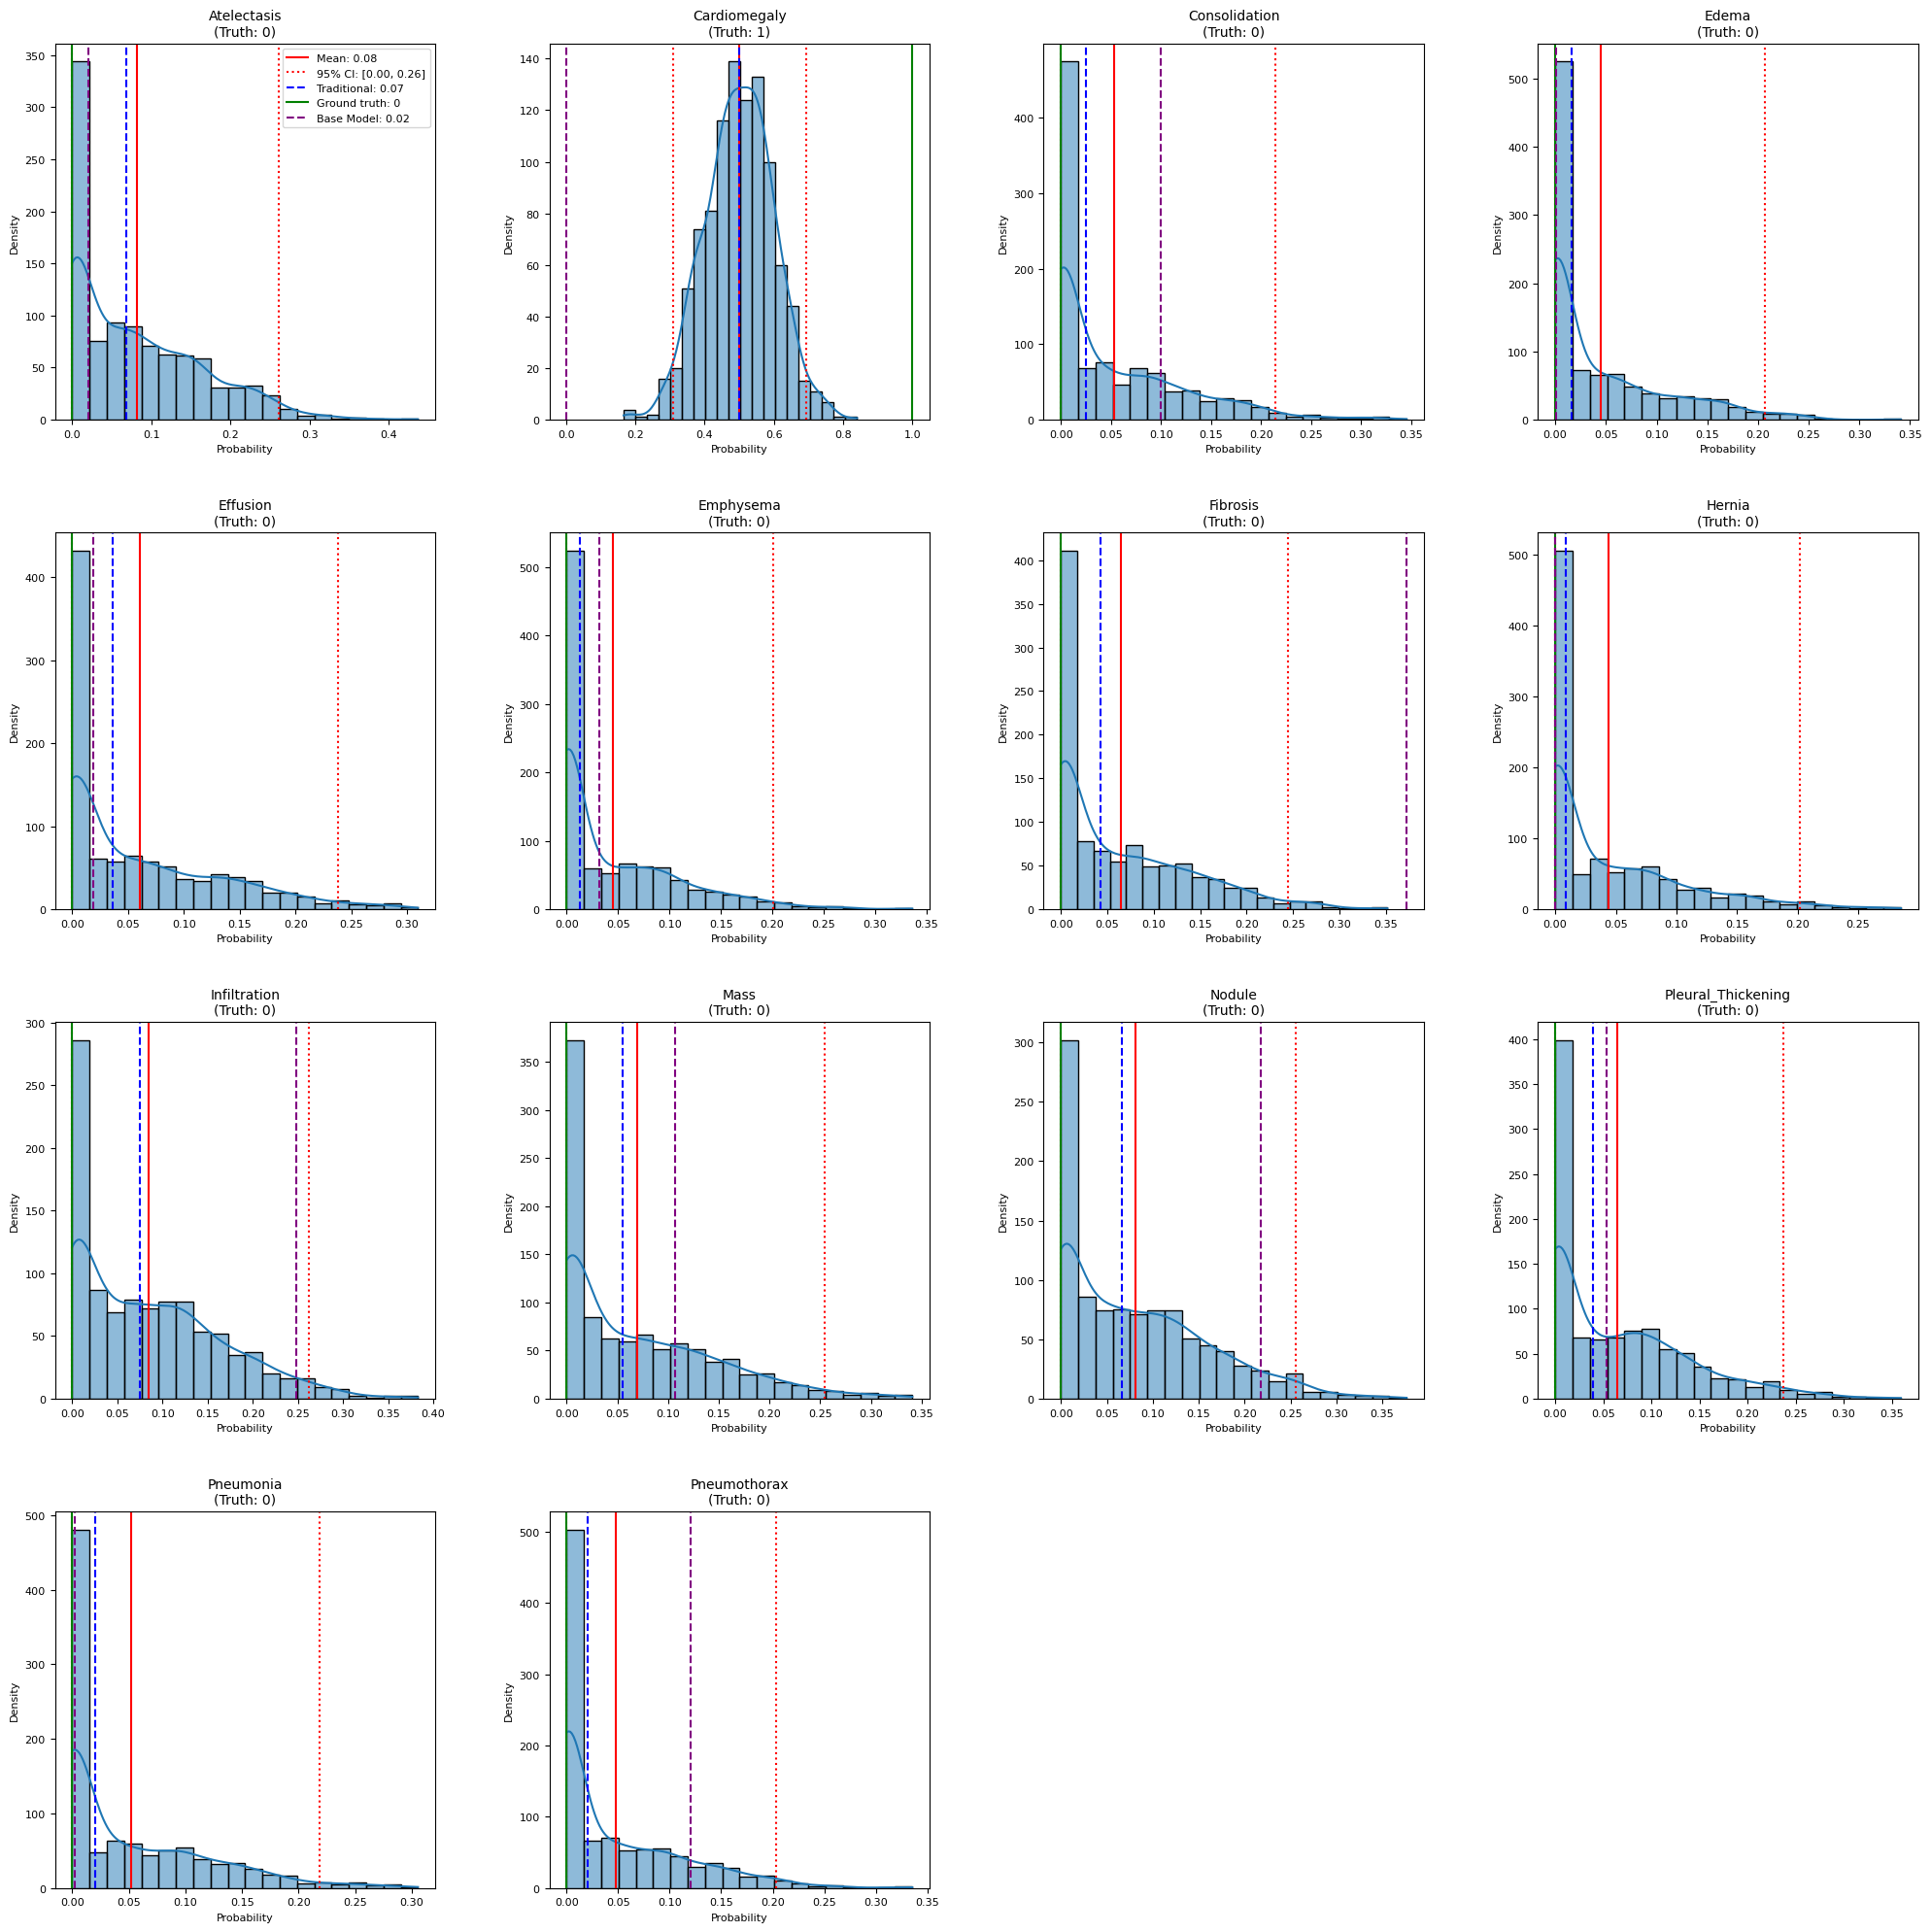

In [ ]:
# Single Diagnosis Example
simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[6],
    idx=6,
    n_samples=1000,
    n_test_samples=3
)


Processing sample 14 with features: {'f0': -20, 'f1': -19, 'f2': -10, 'f3': 15, 'f4': 6, 'f5': -1, 'f6': -1, 'f7': 4, 'f8': 1, 'f9': -12, 'f10': 1, 'f11': 3, 'f12': 2, 'f13': -3, 'f14': -4, 'f15': 0, 'f16': 0, 'f17': 7, 'f18': -1, 'f19': -2, 'f20': 0, 'f21': 4, 'f22': 3, 'f23': 0, 'f24': -1}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 1, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 1, 'Mass': 0, 'Nodule': 1, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.2486 (Ground truth: 0)
  Cardiomegaly: 0.0272 (Ground truth: 0)
  Consolidation: 0.1156 (Ground truth: 0)
  Edema: 0.0578 (Ground truth: 0)
  Effusion: 0.2023 (Ground truth: 1)
  Emphysema: 0.0316 (Ground truth: 0)
  Fibrosis: 0.1156 (Ground truth: 0)
  Hernia: 0.0064 (Ground truth: 0)
  Infiltration: 0.0875 (Ground truth: 1)
  Mass: 0.1908 (Ground truth: 0)
  Nodule: 0.1387 (Ground truth: 1)
  Pleural_Thicke

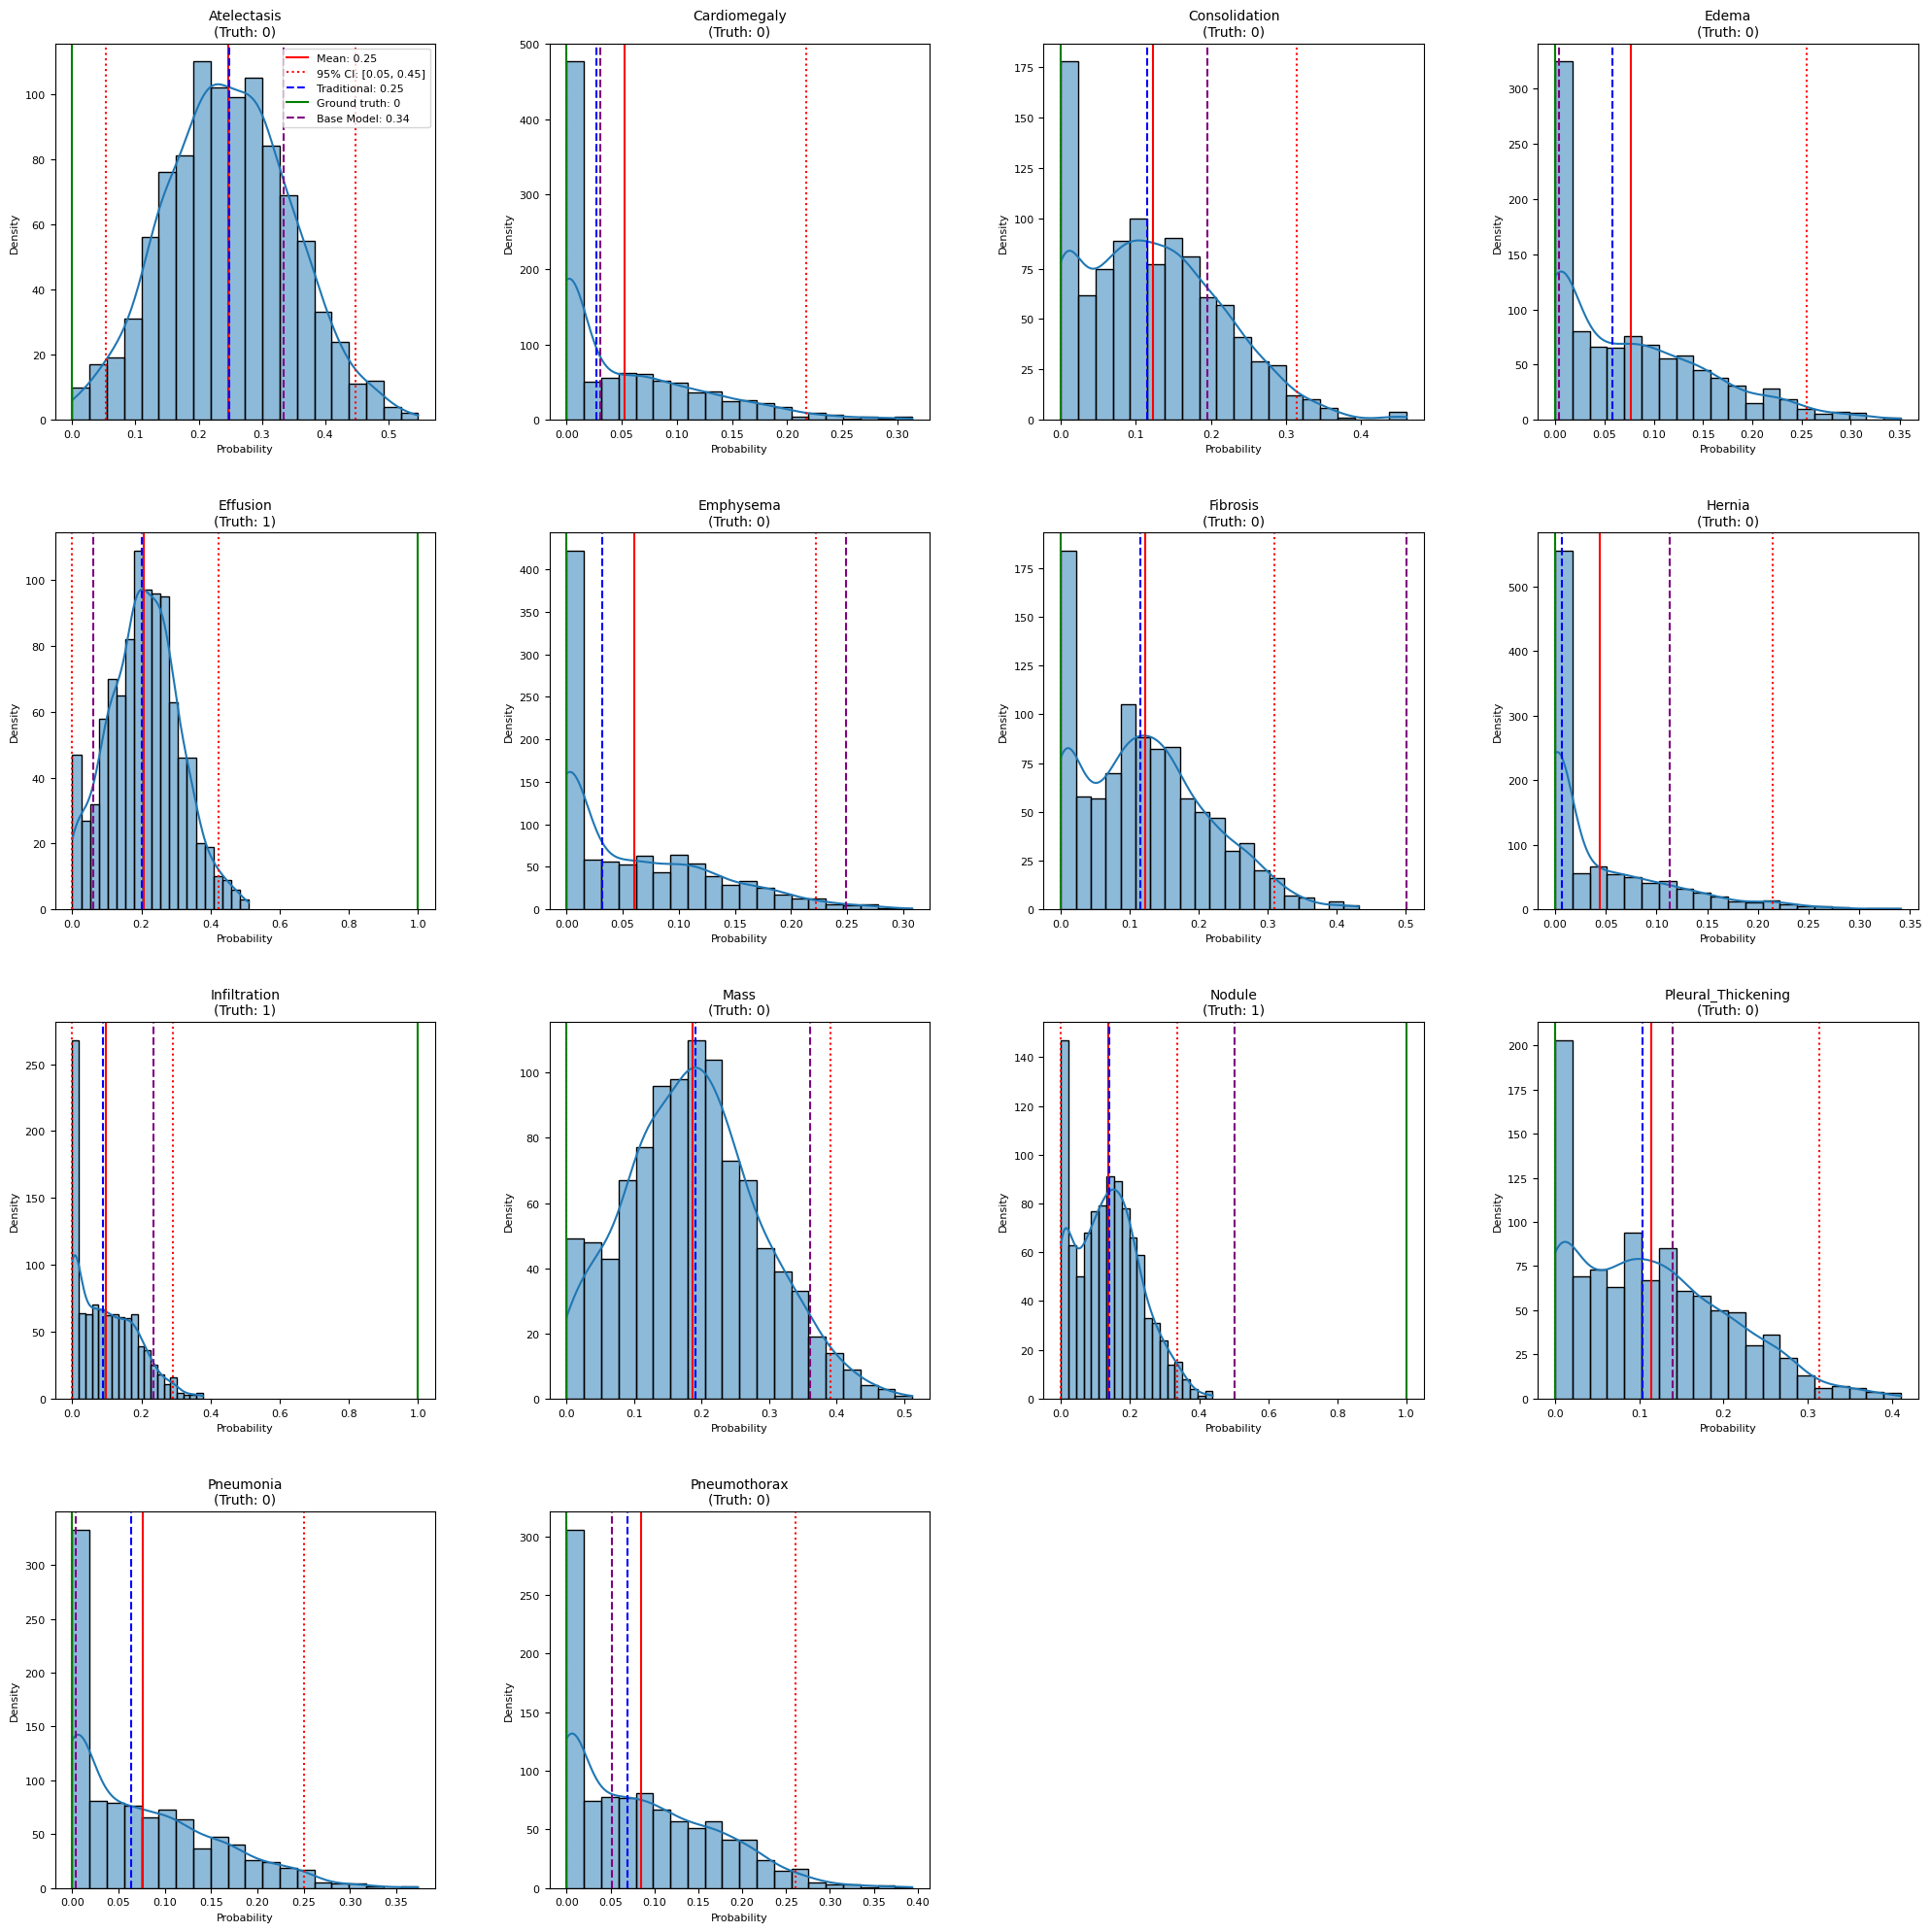

In [ ]:
# Multiple Diagnosis Example
for i in range(1000):
    # Single Diagnosis Example
    result = simplified_inference_test(
        model=bayes_net,
        param_samples=param_samples,
        data=data,
        feature_cols=feature_cols,
        pathology_cols=pathology_cols,
        base_model_pred=preds[i],
        idx=i,
        n_samples=1000,
        n_test_samples=3
    )
    if result != "":
        break